In [158]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KDTree

In [252]:
class Car(object):
    def __init__(self):
        self.track = pd.read_csv('https://raw.githubusercontent.com/KnowchowHQ/rl-in-action/master/C1-RL-Intro/W1S1/track.txt',sep=' ')
        self.kdtree = KDTree(self.track)
        self.__reset__()

    def __reset__(self):
        self.max_steering_deg = 25
        self.min_steering_deg = -25
        self.min_speed = 0 #meter per second
        self.max_speed = 50 #meter per second
        self.speed = 0 #meter per second
        self.steering_deg = 0 #degree
        self.heading_deg = 0 #degrees
        self.x = self.track.x[0]
        self.y = self.track.y[0]
        self.length = 1.0 # length of vehicle in meter
        
    def render(self):
        plt.figure(figsize=(12,8))
        plt.scatter(self.track.x, self.track.y)
        plt.plot(self.track.x[0], self.track.y[0], 'go', markersize=12)
        plt.plot(self.x, self.y, 'r.', markersize=12)
        plt.show()
        
    
    def _to_rad_(deg):
        return deg * np.pi / 180
    
    def _to_deg_(rad):
        return rad*180/np.pi
    
    def __check_off_track__(self):
        dist, ind = self.kdtree.query([[self.x, self.y]], 1)
        car = (round(self.x,2), round(self.y,2))
        closest_x = float(self.track.x[ind[0]])
        closest_y = float(self.track.y[ind[0]])
        closest = (round(closest_x,2),round(closest_y,2))
        assert dist <= 10,\
        f"Game Over!! Your car veered off the track! Car:{car} Closest Point:{closest}"
    
    def move(self, time_step):
        heading = Car._to_rad_(self.heading_deg)
        steering = Car._to_rad_(self.steering_deg)
        
     
        self.x = self.x + self.speed*np.cos(heading)*time_step
        self.y = self.y + self.speed*np.sin(heading)*time_step
     
        new_heading = (heading + self.speed / self.length * steering * time_step) % (np.pi * 2)
        self.heading_deg = Car._to_deg_(new_heading)
        
        self.__check_off_track__()
    
        
    
    def set_steering(self, steer_deg):
        assert self.min_steering_deg <= steer_deg <= self.max_steering_deg,\
        f'Steering angle must be in degree and in the range {self.min_steering_deg},{self.max_steering_deg}'
        
        self.steering_deg = steer_deg
        
        
    def set_speed(self, speed_meter_sec):
        assert self.min_speed <= speed_meter_sec <= self.max_speed,\
        (f'Speed must be in meters per second and in the range {self.min_speed},{self.max_speed}')
        
        self.speed = speed_meter_sec
        
        
    
    def find_nearest_track_points(self,n=5):
        dist, inds = self.kdtree.query([[self.x, self.y]], n)
        inds = list(*inds)
        return self.track.loc[inds]
        

In [253]:
car = Car()

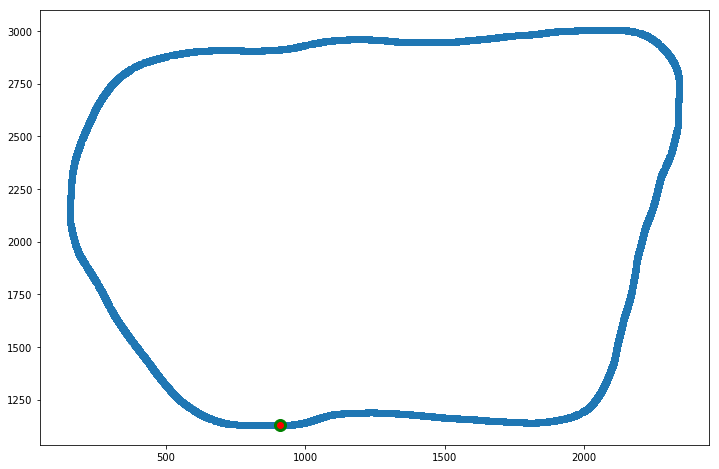

In [254]:
car.render()

57 steps.
Game Over!! Your car veered off the track! Car:(1024.91, 1140.34) Closest Point:(1020.88, 1149.56)


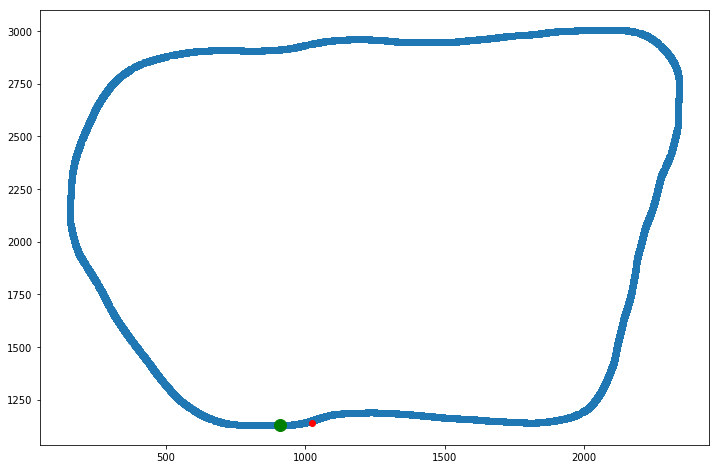

In [255]:
car.__reset__()
car.set_speed(20)
car.set_steering(0.1)

try:
    for i in range(150):
        car.move(.1)
except Exception as err:
    print(f'{i} steps.')
    print(err)
finally:
    car.render()